In [ ]:
!nvidia-smi

Sun Apr 18 13:45:31 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0    32W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import UpSampling2D, GlobalMaxPooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.applications import ResNet50

import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

import time

print('Tensorflow version: ', tf.__version__)
print('TFDS version: ', tfds.__version__)

Tensorflow version:  2.4.1
TFDS version:  4.0.1


In [ ]:
train_ds, val_ds = tfds.load('cifar10', split=['train[:80%]', 'train[80%:]'], 
                             as_supervised=True, shuffle_files=True)

In [ ]:
print('Total samples in train_ds:', tf.data.Dataset.cardinality(train_ds).numpy())
print('Total samples in val_ds:', tf.data.Dataset.cardinality(val_ds).numpy())

Total samples in train_ds: 40000
Total samples in val_ds: 10000


In [ ]:
class_name = ['uçak', 'araba', 'kuş', 'kedi', 'geyik', 'köpek', 'kurbağa', 'at', 'gemi', 'kamyon']

In [ ]:
def one_hot_normalize(images, labels):
  return tf.cast(images, tf.float32) / 255.0, tf.cast(tf.one_hot(labels, 10), tf.int32)

autotune = tf.data.AUTOTUNE

train_ds = train_ds.batch(64).map(one_hot_normalize, num_parallel_calls=autotune).prefetch(autotune)
val_ds = val_ds.batch(64).map(one_hot_normalize, num_parallel_calls=autotune).prefetch(autotune)

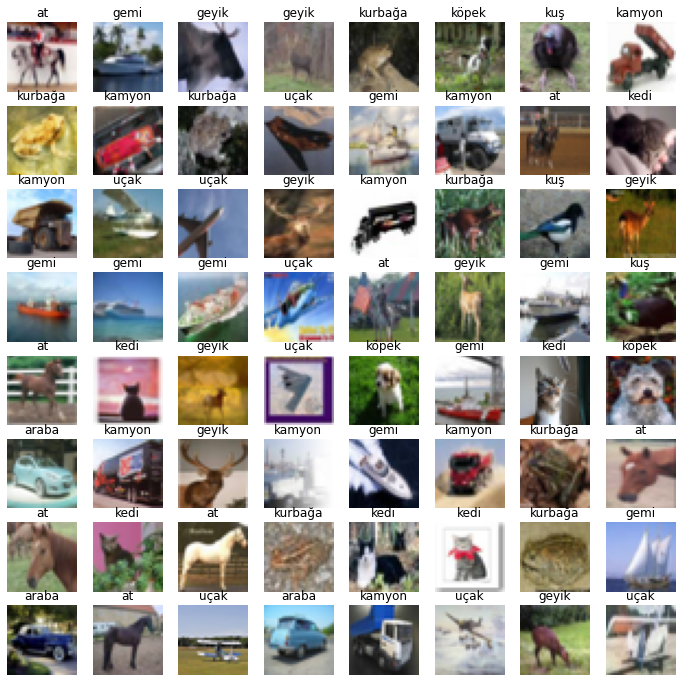

In [ ]:
plt.figure(figsize=(12, 12))

for image, label in train_ds.take(1):
  for i in range(64):
    ax = plt.subplot(8, 8, i + 1)
    plt.imshow(image[i].numpy())
    plt.title(class_name[tf.argmax(label[i]).numpy()])
    plt.axis('off')

In [ ]:
def get_model(get_summary = False):

  resnet = ResNet50(include_top = False, weights = 'imagenet')

  model = tf.keras.Sequential([
                  tf.keras.Input(shape = (32,32,3)),

                  # UpSampling2D((7,7)), resnet: en iyi performans için

                  resnet,

                  GlobalMaxPooling2D(),

                  Dense(512, activation='relu'),
                  Dropout(0.3),
                  Dense(256, activation='relu'),
                  Dense(10)
  ])
  if get_summary:
    model.summary()
  return model

model = get_model(get_summary = True)

model.compile(optimizer=Adam(learning_rate=0.0007), 
              loss = CategoricalCrossentropy(from_logits=True),
              metrics = CategoricalAccuracy())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, None, None, 2048)  23587712  
_________________________________________________________________
global_max_pooling2d (Global (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                2570      
Total params: 24,770,698
Trainable params: 24,717,578
Non-trainable params: 53,120
_______________________________________

In [ ]:
class EpochTimes(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [ ]:
time_callback = EpochTimes()

model.fit(train_ds, epochs = 5, validation_data=val_ds, callbacks = time_callback)

Epoch 1/5
625/625 [==============================] - 51s 68ms/step - loss: 1.6377 - categorical_accuracy: 0.4682 - val_loss: 4.3636 - val_categorical_accuracy: 0.1171
Epoch 2/5
625/625 [==============================] - 37s 58ms/step - loss: 0.9223 - categorical_accuracy: 0.6944 - val_loss: 1.0345 - val_categorical_accuracy: 0.6994
Epoch 3/5
625/625 [==============================] - 36s 58ms/step - loss: 0.7181 - categorical_accuracy: 0.7639 - val_loss: 0.8828 - val_categorical_accuracy: 0.7223
Epoch 4/5
625/625 [==============================] - 36s 58ms/step - loss: 0.5690 - categorical_accuracy: 0.8130 - val_loss: 0.9152 - val_categorical_accuracy: 0.7172
Epoch 5/5
625/625 [==============================] - 36s 58ms/step - loss: 0.4761 - categorical_accuracy: 0.8402 - val_loss: 14.0932 - val_categorical_accuracy: 0.4688


In [ ]:
times_fit_method = time_callback.times
times_fit_method

[50.6353976726532,
 36.55883073806763,
 36.3742733001709,
 36.49166250228882,
 36.31288170814514]

In [ ]:
model = get_model()

In [ ]:
loss = CategoricalCrossentropy(from_logits = True)
optimizer = Adam(learning_rate=0.0007)

train_accuracy = CategoricalAccuracy()
validation_accuracy = CategoricalAccuracy()

In [ ]:
epochs = 5
times_not_optimized = []

for epoch in range(epochs):
    print("\nEpoch %d baslangici" % (epoch+1))
    start_time = time.time()

    # Veri üzerinde batchleri alıp ilerle
    for step, (images_batch, labels_batch) in enumerate(train_ds):
        with tf.GradientTape() as tape:
            logits = model(images_batch, training=True)
            loss_value = loss(labels_batch, logits)
        grads = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        # Accuracy'i güncelle
        train_accuracy.update_state(labels_batch, logits)

    # Metrikleri epoch sonu göster
    train_acc = train_accuracy.result()
    print('Epoch %d icin training accuracy: %.4f' % (epoch+1,float(train_acc)))
    print('Epoch %d icin training loss: %.4f' %(epoch+1,loss_value.numpy()))

    # Metrikler epoch sonunda resetlenmeli
    train_accuracy.reset_states()

    # Validation verisi için batchler üzerinde ilerle
    for images_val_batch, val_labels_batch in val_ds:
        val_logits = model(images_val_batch, training=False)
        loss_val = loss(val_labels_batch, val_logits)

        # Metrikleri güncelle
        validation_accuracy.update_state(val_labels_batch, val_logits)
    val_acc = validation_accuracy.result()
    validation_accuracy.reset_states()
    print("Epoch %d icin validation accuracy: %.4f" %(epoch+1,float(val_acc)))
    print('Epoch %d icin validation loss: %.4f' %(epoch+1,loss_val.numpy()))
    print("Geçen zaman: %.2fs" % (time.time() - start_time))

    times_not_optimized.append((time.time() - start_time))


Epoch 1 baslangici
Epoch 1 icin training accuracy: 0.6002
Epoch 1 icin training loss: 0.9363
Epoch 1 icin validation accuracy: 0.1718
Epoch 1 icin validation loss: 3.1607
Geçen zaman: 103.15s

Epoch 2 baslangici
Epoch 2 icin training accuracy: 0.7285
Epoch 2 icin training loss: 0.8685
Epoch 2 icin validation accuracy: 0.6792
Epoch 2 icin validation loss: 0.8031
Geçen zaman: 102.75s

Epoch 3 baslangici
Epoch 3 icin training accuracy: 0.7818
Epoch 3 icin training loss: 0.6478
Epoch 3 icin validation accuracy: 0.7030
Epoch 3 icin validation loss: 0.6780
Geçen zaman: 102.01s

Epoch 4 baslangici
Epoch 4 icin training accuracy: 0.8276
Epoch 4 icin training loss: 0.6655
Epoch 4 icin validation accuracy: 0.7056
Epoch 4 icin validation loss: 1.1887
Geçen zaman: 101.59s

Epoch 5 baslangici
Epoch 5 icin training accuracy: 0.8500
Epoch 5 icin training loss: 0.3009
Epoch 5 icin validation accuracy: 0.6547
Epoch 5 icin validation loss: 1.1379
Geçen zaman: 101.30s


In [ ]:
model = get_model()

In [ ]:
loss = CategoricalCrossentropy(from_logits = True)
optimizer = Adam(learning_rate=0.0007)

train_accuracy = CategoricalAccuracy()
validation_accuracy = CategoricalAccuracy()

In [ ]:
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        logits = model(x, training=True)
        loss_value = loss(y, logits)
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    train_accuracy.update_state(y, logits)
    return loss_value

In [ ]:
@tf.function
def test_step(x, y):
    val_logits = model(x, training=False)
    loss_value = loss(y, val_logits)
    validation_accuracy.update_state(y, val_logits)
    return loss_value

In [ ]:
epochs = 5
times_optimized = []
for epoch in range(epochs):
    print("\nEpoch %d baslangici" %(epoch+1))
    start_time = time.time()

    # Veri üzerinde batchleri alıp ilerle
    for step, (images_batch, labels_batch) in enumerate(train_ds):
        loss_value = train_step(images_batch, labels_batch)

    # Metrikleri epoch sonu göster
    train_acc = train_accuracy.result()
    print('Epoch %d icin training accuracy: %.4f' %(epoch+1,float(train_acc)))
    print('Epoch %d icin training loss: %.4f' %(epoch+1,loss_value.numpy()))

    # Metrikler epoch sonunda resetlenmeli
    train_accuracy.reset_states()

    # Validation verisi için batchler üzerinde ilerle - her epoch sonunda
    for images_val_batch, val_labels_batch in val_ds:
        loss_val = test_step(images_val_batch, val_labels_batch)

    val_acc = validation_accuracy.result()
    validation_accuracy.reset_states()
    print("Epoch %d icin validation accuracy: %.4f" %(epoch+1,float(val_acc),))
    print('Epoch %d icin validation loss: %.4f' %(epoch+1,loss_val.numpy()))
    print("Geçen zaman: %.2fs" % (time.time() - start_time))

    times_optimized.append(time.time() - start_time)


Epoch 1 baslangici
Epoch 1 icin training accuracy: 0.6132
Epoch 1 icin training loss: 0.9338
Epoch 1 icin validation accuracy: 0.1163
Epoch 1 icin validation loss: 2.6478
Geçen zaman: 34.45s

Epoch 2 baslangici
Epoch 2 icin training accuracy: 0.7430
Epoch 2 icin training loss: 0.6418
Epoch 2 icin validation accuracy: 0.7160
Epoch 2 icin validation loss: 1.8695
Geçen zaman: 28.10s

Epoch 3 baslangici
Epoch 3 icin training accuracy: 0.7930
Epoch 3 icin training loss: 0.4735
Epoch 3 icin validation accuracy: 0.6961
Epoch 3 icin validation loss: 0.7929
Geçen zaman: 28.01s

Epoch 4 baslangici
Epoch 4 icin training accuracy: 0.8293
Epoch 4 icin training loss: 0.5993
Epoch 4 icin validation accuracy: 0.6633
Epoch 4 icin validation loss: 1.1914
Geçen zaman: 28.23s

Epoch 5 baslangici
Epoch 5 icin training accuracy: 0.8508
Epoch 5 icin training loss: 0.2880
Epoch 5 icin validation accuracy: 0.7545
Epoch 5 icin validation loss: 1.4599
Geçen zaman: 27.99s


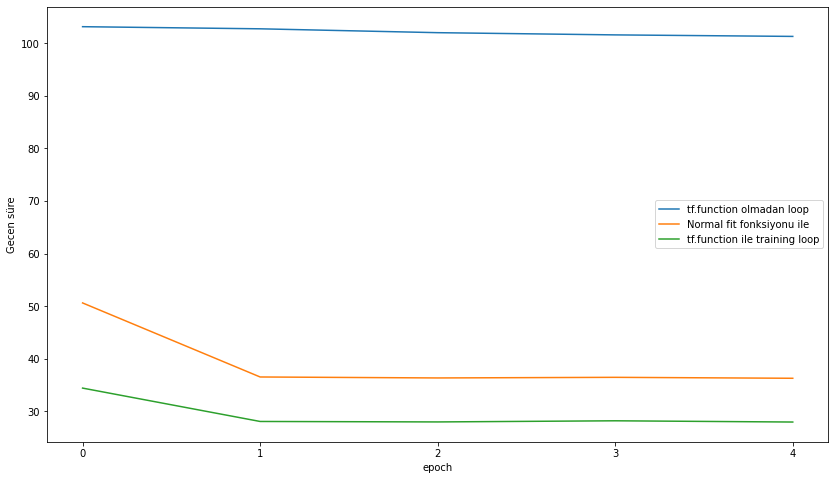

In [ ]:
import math 
x = [0,1,2,3,4]
plt.figure(figsize=(14,8))
plt.plot(times_not_optimized, label = 'tf.function olmadan loop')
plt.plot(times_fit_method, label = 'Normal fit fonksiyonu ile')
plt.plot(times_optimized, label = 'tf.function ile training loop')
plt.legend(loc = 'best')
plt.xlabel('epoch')
plt.ylabel('Gecen süre')
plt.xticks(range(min(x), math.ceil(max(x))+1))
plt.show()